![alt text](http://library.columbia.edu/content/libraryweb/locations/business/_jcr_content/layout_featuredcontent/image.img.jpg/1369336790208.jpg)
#What do we know about Density's data?

In [40]:
import pandas as pd
import datetime
import seaborn as sns
import pylab as plt
import numpy as np
import requests
%matplotlib inline 

In [41]:
raw = pd.read_csv('../scripts/demo_data.csv', parse_dates = [0], index_col = 0)
buildings = pd.read_csv('../scripts/buildings.csv', index_col = 0, header = None, squeeze = True)

In [42]:
plt.rcParams.update({'font.size': 28})
sns.set_context("talk")
sns.set_style('darkgrid')

##[CUIT](https://cuit.columbia.edu/) has supplied us with the following data set

![alt text](https://github.com/adicu/density/blob/master/density/static/favicon.png?raw=true)

###We receive device counts from specific routers aggregated into 15 minute intervals

Devices connect to wifi routers across Columbia's campus.  CUIT aggregates device collection data by building and by floor and supplies with a live count of the number of devices connected at each location every 15 minutes.

In [43]:
raw.head()

,group_id,group_name,parent_id,parent_name,client_count
dump_time,,,,,
2014-06-30 17:15:00,147,Architectural and Fine Arts Library 1,146,Avery,2
2014-06-30 17:15:00,132,Butler Library 4,103,Butler,49
2014-06-30 17:15:00,150,Lerner 1,84,Lerner,0
2014-06-30 17:15:00,155,JJ's Place,75,John Jay,5
2014-06-30 17:15:00,23,Uris/Watson Library,2,Uris,260


---

#What spaces do we have?

##We have various Libraries, John Jay, and Lerner

In [44]:
print buildings

0
Architectural and Fine Arts Library 1                 Avery
Architectural and Fine Arts Library 2                 Avery
Architectural and Fine Arts Library 3                 Avery
Butler Library 2                                     Butler
Butler Library 3                                     Butler
Butler Library 4                                     Butler
Butler Library 5                                     Butler
Butler Library 6                                     Butler
Butler Library stk                                   Butler
JJ's Place                                         John Jay
John Jay Dining Hall                               John Jay
Lehman Library 2                             Lehman LIbrary
Lehman Library 3                             Lehman LIbrary
Lerner 1                                             Lerner
Lerner 2                                             Lerner
Lerner 3                                             Lerner
Lerner 4                              

---

#Just how full is a study space?



![alt text](http://www.hercampus.com/sites/default/files/2013/12/02/4192655241_df21ba1706.jpg)


##There's an obvious difference beteween a space that is unusually crowded like during orgo night, and a typical busy day

![alt text](http://library.columbia.edu/content/libraryweb/locations/butler/_jcr_content/layout_featuredcontent/image.img.jpg/1368472856821.jpg)

##Density assumes that capacity is relative to fullness on an average day, not on outlier days

##How do we do that? By considering what the average day like at each space 

In [45]:
raw['hrfrac'] = raw.index.hour + raw.index.minute/60.

In [46]:
def dayplot(plotfn, title):
    f, ax = plt.subplots(figsize=(9, 7))
    plotfn.plot(ax=ax)
    plt.title(title)
    plt.tight_layout()
    plt.xticks([0,3,6,9,12,15,18,21])
    plt.ylabel('Devices')
    plt.xlabel('Time of Day')

##On an average day at Columbia, device count grows until it stablizes for the day

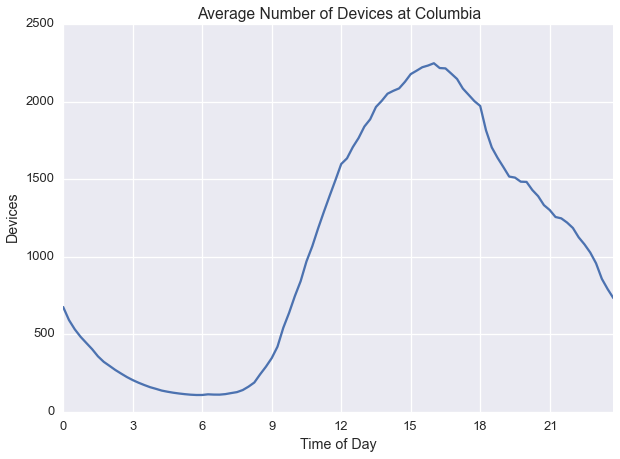

In [47]:
totalday = pd.crosstab(raw.hrfrac, raw.index.date, values=raw.client_count, aggfunc=pd.Series.sum)

dayplot(totalday.mean(axis=1), 'Average Number of Devices at Columbia')

#Capacity is the level at which population growth stabilizes

###For the capacity of whole campus of Columbia, it would be the following

In [48]:
def find_capacity_overall(total_count):
    avg_day = total_count.mean(axis=1)
    return avg_day.max()

In [49]:
print find_capacity_overall(totalday)

2248.41255605


---

#Different spaces have different properties

In [50]:
tabs = pd.crosstab(raw.hrfrac, raw.group_name, raw.client_count, aggfunc=pd.Series.mean)

In [51]:
def bldg_plot(bldg):
    floors = list(buildings[buildings == bldg].index)
    title = 'Average Daily Device Count in %s' % bldg
    dayplot(tabs[floors], title)

##For example, Butler library behaves very differently from John Jay:

###This is Butler:

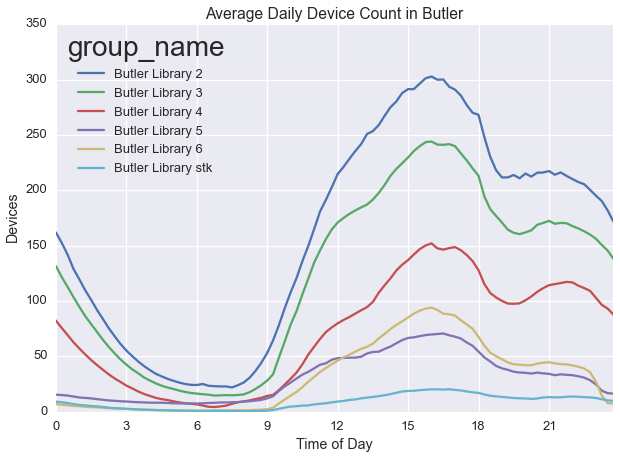

In [52]:
bldg_plot('Butler')

People tend to come in after lunch, take a break for dinner, and work late into the night.

###This is John Jay:

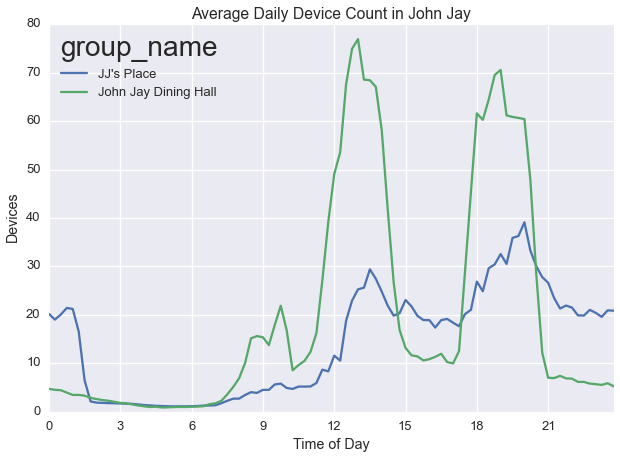

In [53]:
bldg_plot('John Jay')

The dining halls are most crowded around mealtimes.

---

#How does campus population vary over time?

##We can find differences in population based on changes in semesters, exams, and holidays

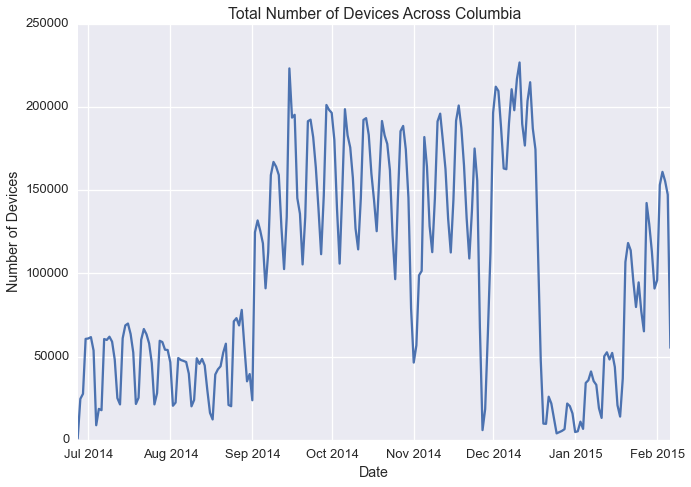

In [54]:
f, ax = plt.subplots(figsize=(10, 7))
raw.groupby(raw.index.date).client_count.sum().plot(ax=ax)
plt.tight_layout()
plt.title('Total Number of Devices Across Columbia')
plt.ylabel('Number of Devices')
plt.xlabel('Date')

There's a clear weekly cycle in the number of devices connected across campus.

##Let's remove the weekly cycle by grouping the data into weeks

In [55]:
raw['date'] = raw.index.date
raw['weekofyear'] = raw.index.weekofyear
weeks = raw['2014-06-30':'2015-02-01'].groupby('weekofyear').client_count.sum()
weeks
weeks.index = list(weeks[weeks.index < 27].index + 52) + list(weeks.index[5:])
weeks = weeks.sort_index()

###Smoothing out the data by grouping by week allows us to see differences in semesters and holidays more clearly

E.g. the big drop around Thanksgiving and the following spike for Finals

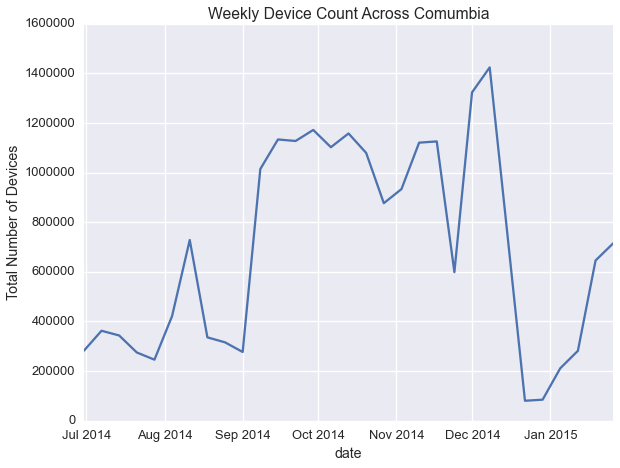

In [56]:
f, ax = plt.subplots(figsize=(9, 7))
weeks.index = raw[raw.index.dayofweek == 0]['2014-06-30':'2015-02-01']['date'].drop_duplicates()
weeks.plot(ax=ax)
plt.tight_layout()
plt.title('Weekly Device Count Across Comumbia')
plt.ylabel('Total Number of Devices')

Aggregating the data by week allows us to see that there's a jump in the number of devices when the semester starts.  We also see a dip for fall break and Thanksgiving and a spike for finals.  Winter break is also visible following the dramatic drop in device count.

---

##How does day of the week affect study habits?

###People don't study on weekends:

([<matplotlib.axis.XTick at 0x11b875910>,
 <a list of 7 Text xticklabel objects>)

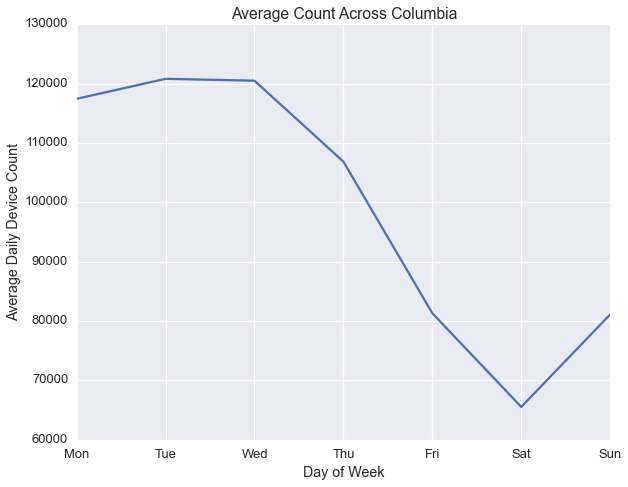

In [57]:
f, ax = plt.subplots(figsize=(9, 7))
dailycounts = raw.groupby(raw.date).client_count.sum()
dailycounts.index = pd.to_datetime(dailycounts.index)
dailycounts.groupby(dailycounts.index.dayofweek).mean().plot(ax=ax)
plt.tight_layout()
plt.title('Average Count Across Columbia')
plt.ylabel('Average Daily Device Count')
plt.xlabel('Day of Week')
weekday = 'Mon Tue Wed Thu Fri Sat Sun'.split()
plt.xticks(range(7), weekday)

In [58]:
fall = pd.crosstab(raw.index, raw.group_name, raw.client_count, aggfunc=pd.Series.sum)

##We can also find days with unusually high number of devices

In [59]:
max_days = [d.strftime('%Y-%m-%d') for d in fall.apply(lambda x: x.argmax())]
max_days = pd.Series(max_days, index = fall.columns)
max_day_table = pd.DataFrame(columns = max_days.index, index = sorted(raw.hrfrac.drop_duplicates()))

for d in max_days.index:
    data = fall[d].ix[max_days[d]]
    data = fall[d].ix[max_days[d]]
    data.index = data.index.hour + data.index.minute / 60.
    max_day_table[d] = data

In [60]:
str(max_days.ix['Roone Arledge Auditorium'])

'2014-08-28'

In [61]:
def maxplot(bldg):
    dayplot(max_day_table[bldg], 'Max Device Counts in %s' % (bldg))
    labels = str(max_days.ix[bldg])
    print labels 
    plt.legend([labels], loc = 2)

Our plots show the days with the max. number of devices recorded at any time at that location.  Using these graphs, we can identify special days during the school year.

##Like NSOP

We see multiple spikes in Roone Arledge Auditorium around the same time as orientation. 

2014-08-28


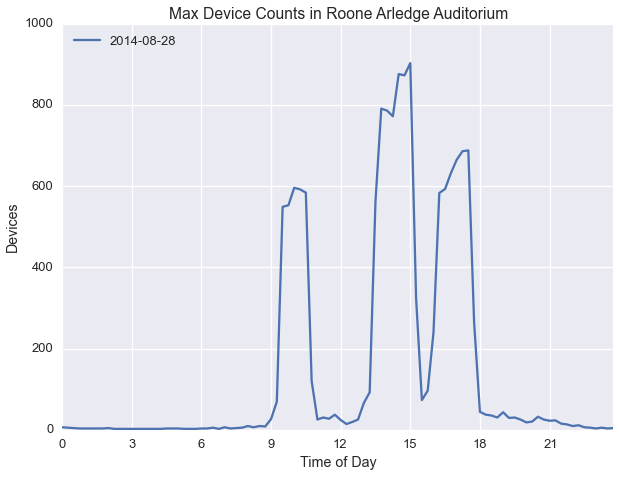

In [62]:
maxplot('Roone Arledge Auditorium')

##And Orgo Night!

Notice the spike in Butler 2 around midnight.

2014-12-12


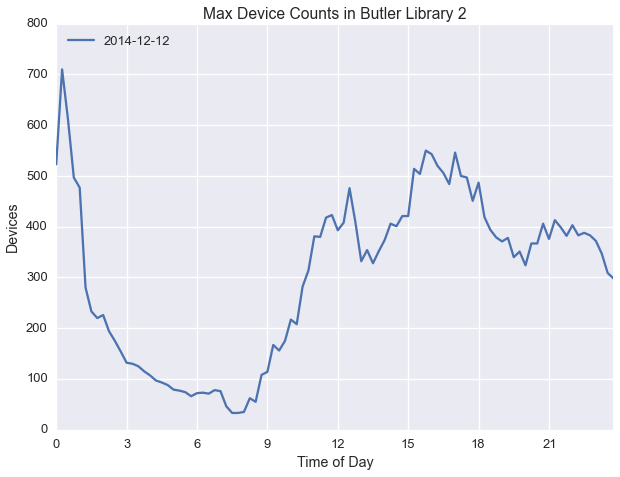

In [63]:
maxplot('Butler Library 2')

##For more tools with the Density API, check out Chris Mulligan's [Relative Density App!](https://chmullig.shinyapps.io/relative_density/)

#Check out our [API](http://density.adicu.com/docs) to use our data!